## Подключение библиотек и определение класса Dataset

In [67]:

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from decomposition import DecompositionLayer
torch.set_num_threads(9)

class MyDataset(TensorDataset):
    def __init__(self, data, window, output):
        self.data = data
        self.window = window
        self.output = output

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        y = self.data[index+self.window:index+self.window+self.output]
        return x, y

    def __len__(self):
        return len(self.data) - self.window - self.output

## Определение параметров модели

In [68]:
input_size = 30
pred = input_size
learning_rate = 0.0001
output_size = 100
data_size  = 5000
step = 1
m = 10 #на сколько шагов предсказать
data_set = 10000
column_name = "HUFL"
model_name = f"update_model_v8_L1_SGD_{column_name}_input{input_size}_output{output_size}"


## Класс деокмпозиции временного ряда для получение сезонной и трендовой составляющей

In [69]:
class DecompositionLayer(nn.Module):
    """
    Returns the trend and the seasonal parts of the time series.
    """

    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) # moving average 

    def forward(self, x):
        """Input shape: Batch x Time x EMBED_DIM"""
        # padding on the both ends of time series
        num_of_pads = (self.kernel_size) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        # calculate the trend and seasonal part of the series
        x_trend = self.avg(x_padded.permute(0, 2, 1))[:,:,:-1].permute(0, 2, 1)
        #print(x_trend.shape)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

## Класс DLinear и функция для обучения модели

In [70]:
class DLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DLinearModel, self).__init__()
        self.linear_seasonal = nn.Linear(input_size, output_size)
        self.linear_trend = nn.Linear(input_size, output_size)
        self.decomposition = DecompositionLayer(input_size)
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, context):
        seasonal, trend = self.decomposition(context)
        #print(seasonal, trend)
        seasonal_output = self.linear_seasonal(seasonal.reshape(1, 1, -1))
        trend_output = self.linear_trend(trend.reshape(1, 1, -1))
        
        return seasonal_output + trend_output


def train_model(model, dataloader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        print("Epoch = ", epoch)
        for X, Y in dataloader:
            
            optimizer.zero_grad()
            output = model.forward(X)
            #print(torch.tensor([output.tolist()]), Y)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()


In [71]:

data = pd.read_csv('ETTh1.csv')  
X = torch.tensor(data[column_name].values[:data_size:step], dtype=torch.float32).view(-1, 1)
x = pd.read_csv("ETTh1.csv").HUFL

In [72]:
model = DLinearModel(input_size, output_size)
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#TODO: переписать dataloader для правильно обучения

window_size = input_size  # Размер окна для rolling window forecasting
#переписать

dataset = MyDataset(X, window_size, output_size)

#print(x.rolling(window_size))

dataloader = DataLoader(dataset)#, shuffle=True)

In [73]:
len(dataloader)

4870

In [74]:
train_model(model, dataloader, criterion, optimizer)


Epoch =  0


c:\Users\evgen\miniconda3\envs\MyDLinear\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1, 100, 1])) that is different to the input size (torch.Size([1, 1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch =  1
Epoch =  2
Epoch =  3
Epoch =  4
Epoch =  5
Epoch =  6
Epoch =  7
Epoch =  8
Epoch =  9
Epoch =  10
Epoch =  11
Epoch =  12
Epoch =  13
Epoch =  14
Epoch =  15
Epoch =  16
Epoch =  17
Epoch =  18
Epoch =  19
Epoch =  20
Epoch =  21
Epoch =  22
Epoch =  23
Epoch =  24
Epoch =  25
Epoch =  26
Epoch =  27
Epoch =  28
Epoch =  29
Epoch =  30
Epoch =  31
Epoch =  32
Epoch =  33
Epoch =  34
Epoch =  35
Epoch =  36
Epoch =  37
Epoch =  38
Epoch =  39
Epoch =  40
Epoch =  41
Epoch =  42
Epoch =  43
Epoch =  44
Epoch =  45
Epoch =  46
Epoch =  47
Epoch =  48
Epoch =  49
Epoch =  50
Epoch =  51
Epoch =  52
Epoch =  53
Epoch =  54
Epoch =  55
Epoch =  56
Epoch =  57
Epoch =  58
Epoch =  59
Epoch =  60
Epoch =  61
Epoch =  62
Epoch =  63
Epoch =  64
Epoch =  65
Epoch =  66
Epoch =  67
Epoch =  68
Epoch =  69
Epoch =  70
Epoch =  71
Epoch =  72
Epoch =  73
Epoch =  74
Epoch =  75
Epoch =  76
Epoch =  77
Epoch =  78
Epoch =  79
Epoch =  80
Epoch =  81
Epoch =  82
Epoch =  83
Epoch =  84
E

In [75]:
torch.save(model.state_dict(), model_name)

In [76]:
model.load_state_dict(torch.load(model_name))
model.eval()

DLinearModel(
  (linear_seasonal): Linear(in_features=30, out_features=100, bias=True)
  (linear_trend): Linear(in_features=30, out_features=100, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(30,), stride=(1,), padding=(0,))
  )
)

In [77]:
model.parameters

<bound method Module.parameters of DLinearModel(
  (linear_seasonal): Linear(in_features=30, out_features=100, bias=True)
  (linear_trend): Linear(in_features=30, out_features=100, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(30,), stride=(1,), padding=(0,))
  )
)>

In [78]:
def predict_future_values(model, X_f, window_size, m):
    #predicted_values = initial_values.clone().detach().view(-1).tolist()
    predicted_values = []
    
    for i in range(m):
        
        
        #проверить что модель принимает нужный набор значений
        #last_X = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        # last_X_t = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        
        prediction = model(X_f)

        
        predicted_values.append(prediction.tolist()[-1][-1][-1])
        if(window_size > i):
            
            X_f = torch.tensor(data['HUFL'].values[data_size-window_size+i+1::step] + predicted_values, dtype=torch.float32).reshape(1, 1, -1)
        else:
            X_f = torch.tensor(predicted_values, dtype=torch.float32).reshape(1, 1, -1)
            
        

    return predicted_values

In [79]:
initial_values = torch.cat([X[-input_size:]]).reshape(1, 1, -1)

pred = input_size
X_f = torch.tensor(data[column_name].values[data_set-pred:data_set-pred+pred*step:step], dtype=torch.float32).view(-1, 1)
print(X_f)
dataset_f = MyDataset(X_f, pred, output_size)
print(dataset_f.data)
#print(x.rolling(window_size))

dataloader_f = DataLoader(dataset_f)#, shuffle=True)

X_f


tensor([[  8.7070],
        [  7.1000],
        [  0.6700],
        [  7.1670],
        [ -8.4390],
        [  2.2770],
        [  3.2150],
        [  6.6310],
        [ 10.0470],
        [ 11.7210],
        [ 13.1280],
        [ 12.0560],
        [ 14.6020],
        [ 15.1370],
        [ 15.2710],
        [ 14.9370],
        [ 14.8700],
        [ 14.7360],
        [ 15.0700],
        [ 13.7980],
        [ 16.0080],
        [ 13.1280],
        [  5.9610],
        [ -2.0090],
        [ -5.4250],
        [ -8.7740],
        [-10.0470],
        [ -3.9520],
        [ -5.4920],
        [ -6.0280]])
tensor([[  8.7070],
        [  7.1000],
        [  0.6700],
        [  7.1670],
        [ -8.4390],
        [  2.2770],
        [  3.2150],
        [  6.6310],
        [ 10.0470],
        [ 11.7210],
        [ 13.1280],
        [ 12.0560],
        [ 14.6020],
        [ 15.1370],
        [ 15.2710],
        [ 14.9370],
        [ 14.8700],
        [ 14.7360],
        [ 15.0700],
        [ 13.7980],

tensor([[  8.7070],
        [  7.1000],
        [  0.6700],
        [  7.1670],
        [ -8.4390],
        [  2.2770],
        [  3.2150],
        [  6.6310],
        [ 10.0470],
        [ 11.7210],
        [ 13.1280],
        [ 12.0560],
        [ 14.6020],
        [ 15.1370],
        [ 15.2710],
        [ 14.9370],
        [ 14.8700],
        [ 14.7360],
        [ 15.0700],
        [ 13.7980],
        [ 16.0080],
        [ 13.1280],
        [  5.9610],
        [ -2.0090],
        [ -5.4250],
        [ -8.7740],
        [-10.0470],
        [ -3.9520],
        [ -5.4920],
        [ -6.0280]])

In [80]:
X_t = X_f.tolist()
X_t

[[8.706999778747559],
 [7.099999904632568],
 [0.6700000166893005],
 [7.166999816894531],
 [-8.439000129699707],
 [2.2769999504089355],
 [3.2149999141693115],
 [6.63100004196167],
 [10.04699993133545],
 [11.720999717712402],
 [13.128000259399414],
 [12.055999755859375],
 [14.60200023651123],
 [15.13700008392334],
 [15.270999908447266],
 [14.937000274658203],
 [14.869999885559082],
 [14.736000061035156],
 [15.069999694824219],
 [13.79800033569336],
 [16.007999420166016],
 [13.128000259399414],
 [5.960999965667725],
 [-2.009000062942505],
 [-5.425000190734863],
 [-8.77400016784668],
 [-10.04699993133545],
 [-3.9519999027252197],
 [-5.492000102996826],
 [-6.0279998779296875]]

In [81]:

predicted_values = []




    
X = torch.tensor([X_t])
prediction = model(X)
predicted_values = prediction.tolist()[-1][-1]

      
    


future_predictions = predicted_values

In [82]:
predicted_values

[5.956358909606934,
 6.933590888977051,
 6.777189254760742,
 5.7496819496154785,
 8.659233093261719,
 8.029409408569336,
 8.011198043823242,
 6.483319282531738,
 5.142743110656738,
 5.1075520515441895,
 9.2114896774292,
 4.868801116943359,
 8.712087631225586,
 5.602306365966797,
 5.38297176361084,
 6.4282402992248535,
 7.868391990661621,
 7.7661027908325195,
 2.8243298530578613,
 5.817690849304199,
 4.972701549530029,
 7.076063632965088,
 4.509593486785889,
 6.0513176918029785,
 5.616278648376465,
 5.123320579528809,
 3.8689515590667725,
 5.300820350646973,
 6.103440761566162,
 5.946770191192627,
 5.794895648956299,
 3.8546273708343506,
 7.031060218811035,
 7.4141082763671875,
 5.237613201141357,
 7.711724281311035,
 5.5739006996154785,
 8.278650283813477,
 5.630365371704102,
 7.737939834594727,
 7.051161766052246,
 8.507862091064453,
 3.944385051727295,
 6.707540512084961,
 7.684453964233398,
 6.148988246917725,
 6.721774101257324,
 7.453000545501709,
 6.838212013244629,
 5.3283834457

In [83]:
future_predictions

[5.956358909606934,
 6.933590888977051,
 6.777189254760742,
 5.7496819496154785,
 8.659233093261719,
 8.029409408569336,
 8.011198043823242,
 6.483319282531738,
 5.142743110656738,
 5.1075520515441895,
 9.2114896774292,
 4.868801116943359,
 8.712087631225586,
 5.602306365966797,
 5.38297176361084,
 6.4282402992248535,
 7.868391990661621,
 7.7661027908325195,
 2.8243298530578613,
 5.817690849304199,
 4.972701549530029,
 7.076063632965088,
 4.509593486785889,
 6.0513176918029785,
 5.616278648376465,
 5.123320579528809,
 3.8689515590667725,
 5.300820350646973,
 6.103440761566162,
 5.946770191192627,
 5.794895648956299,
 3.8546273708343506,
 7.031060218811035,
 7.4141082763671875,
 5.237613201141357,
 7.711724281311035,
 5.5739006996154785,
 8.278650283813477,
 5.630365371704102,
 7.737939834594727,
 7.051161766052246,
 8.507862091064453,
 3.944385051727295,
 6.707540512084961,
 7.684453964233398,
 6.148988246917725,
 6.721774101257324,
 7.453000545501709,
 6.838212013244629,
 5.3283834457

In [84]:
len(future_predictions)

100

Future Predictions: [5.956358909606934, 6.933590888977051, 6.777189254760742, 5.7496819496154785, 8.659233093261719, 8.029409408569336, 8.011198043823242, 6.483319282531738, 5.142743110656738, 5.1075520515441895, 9.2114896774292, 4.868801116943359, 8.712087631225586, 5.602306365966797, 5.38297176361084, 6.4282402992248535, 7.868391990661621, 7.7661027908325195, 2.8243298530578613, 5.817690849304199, 4.972701549530029, 7.076063632965088, 4.509593486785889, 6.0513176918029785, 5.616278648376465, 5.123320579528809, 3.8689515590667725, 5.300820350646973, 6.103440761566162, 5.946770191192627, 5.794895648956299, 3.8546273708343506, 7.031060218811035, 7.4141082763671875, 5.237613201141357, 7.711724281311035, 5.5739006996154785, 8.278650283813477, 5.630365371704102, 7.737939834594727, 7.051161766052246, 8.507862091064453, 3.944385051727295, 6.707540512084961, 7.684453964233398, 6.148988246917725, 6.721774101257324, 7.453000545501709, 6.838212013244629, 5.328383445739746, 7.123652458190918, 5.1

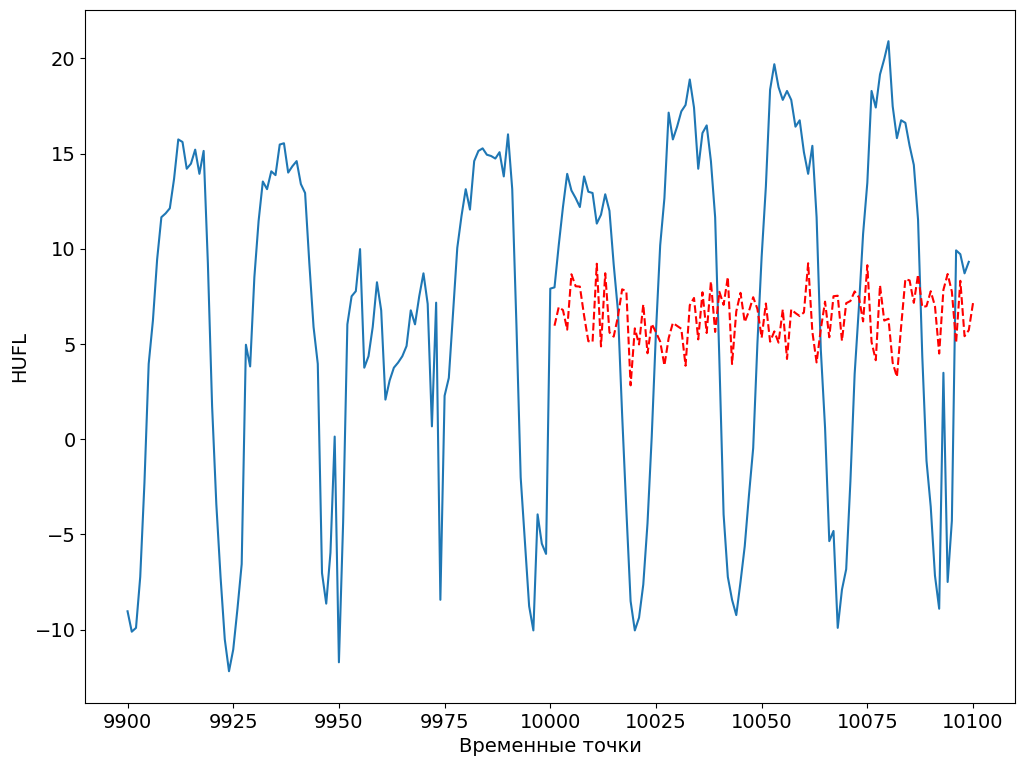

In [85]:

print("Future Predictions:", future_predictions)
time = [data_set-output_size*step+i*step for i in range(2*output_size)]
print(output_size)
plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams.update({'font.size': 14})
plt.plot(time, data[column_name].values[data_set-output_size*step:data_set+(output_size)*step:step])
#plt.plot(, )
pred = data[column_name].values[data_set-1]
time = [data_set+1+i*step for i in range(output_size)]

    
plt.plot(time, future_predictions[::], 'r--')
#plt.title(model_name)
plt.xlabel('Временные точки', fontsize=14)
plt.ylabel('HUFL', fontsize=14)
plt.show()
#plt.savefig(model_name+"2", dpi=1000)




In [86]:
i = [data_set+1+i*step for i in range(output_size)]

import numpy as np

actual = np.array([data[column_name].values[k] for k in i])
prediction = np.array(future_predictions)

l1_loss = abs(actual - prediction)

"""
Output:
[0 1 2 2]
"""

mae_cost = l1_loss.mean()
print(mae_cost)

8.682631256878375


In [87]:
i = [data_set+1+i*step for i in range(output_size)]

import numpy as np

actual = np.array([data[column_name].values[k] for k in i])
prediction = np.array(future_predictions)

l1_loss = abs(actual+1 - prediction-1)/abs(actual+1)

"""
Output:
[0 1 2 2]
"""

mape_cost = np.sum(l1_loss)/output_size
print(mape_cost)

1.8840263161282849


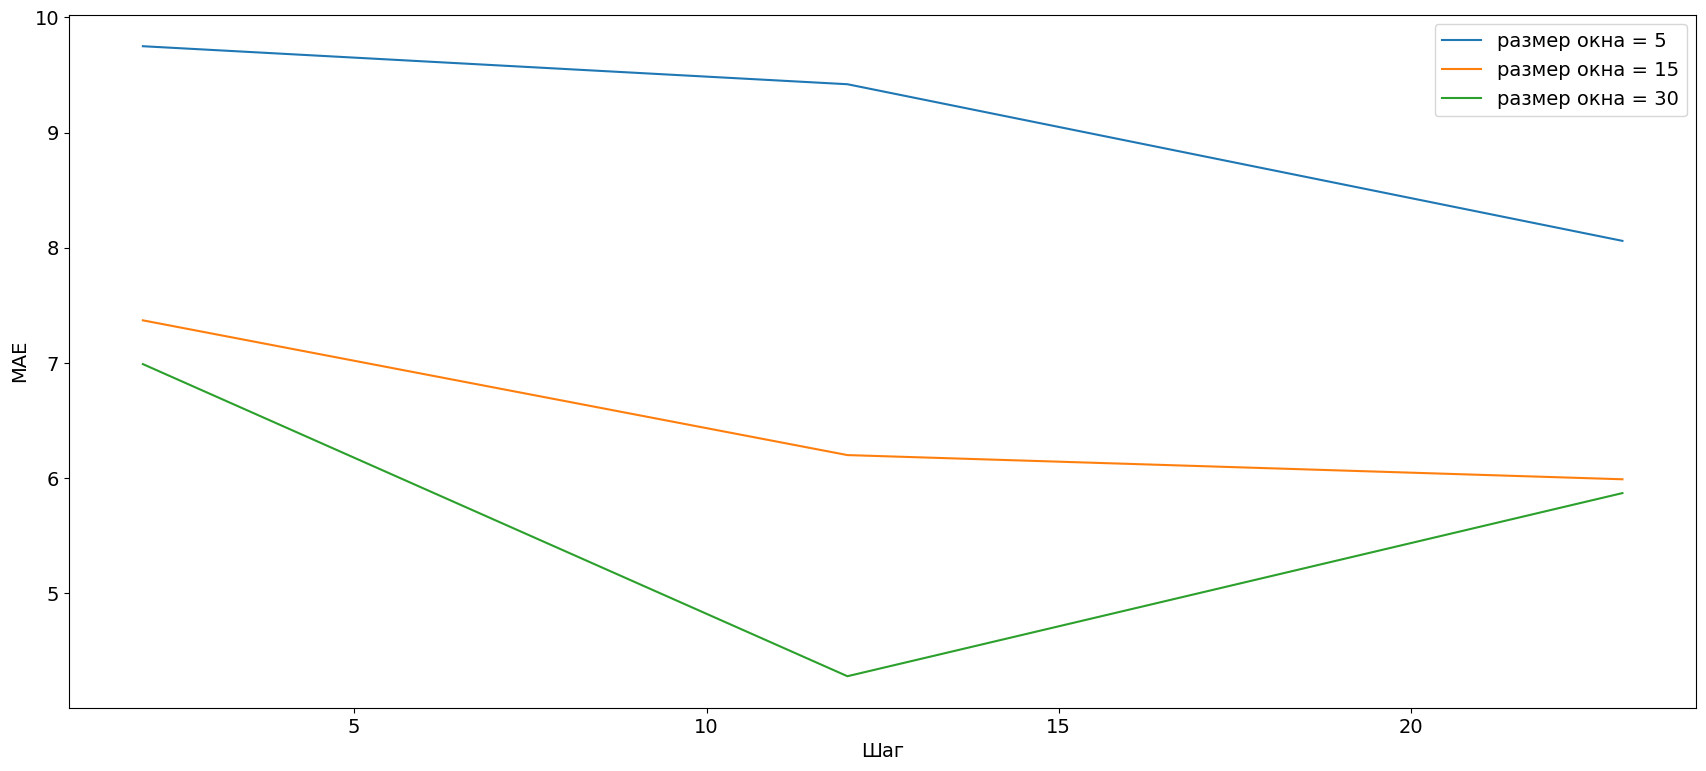

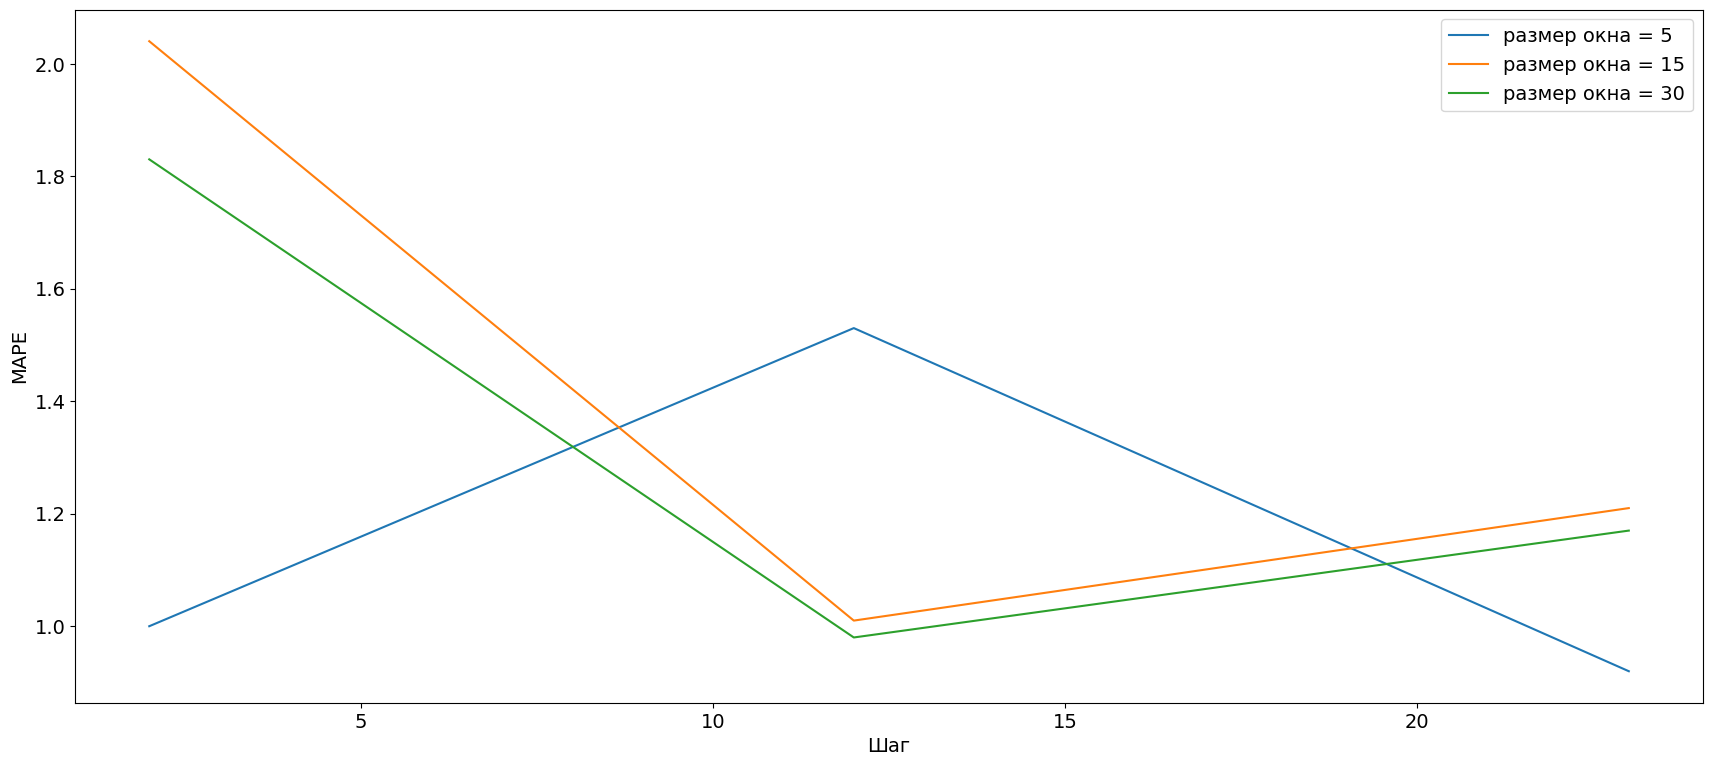

In [88]:
MAE_5 = [9.75, 9.42, 8.06]
MAE_15 = [7.37, 6.20, 5.99]
MAE_30 = [6.99, 4.28, 5.87]

MAPE_5 = [1.00, 1.53,  0.92]
MAPE_15 = [2.04, 1.01, 1.21]
MAPE_30 = [1.83, 0.98, 1.17]

steps = [2,12,23]

plt.rcParams["figure.figsize"] = (21,9)
plt.plot(steps, MAE_5, label='размер окна = 5')
plt.plot(steps, MAE_15, label='размер окна = 15')
plt.plot(steps, MAE_30, label='размер окна = 30')
# plt.title("MAE")
plt.xlabel('Шаг', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.legend()
plt.show()


plt.plot(steps, MAPE_5, label='размер окна = 5')
plt.plot(steps, MAPE_15, label='размер окна = 15')
plt.plot(steps, MAPE_30, label='размер окна = 30')
# plt.title("MAPE")
plt.xlabel('Шаг', fontsize=14)
plt.ylabel('MAPE', fontsize=14)
plt.legend()
plt.show()

## Тест 1
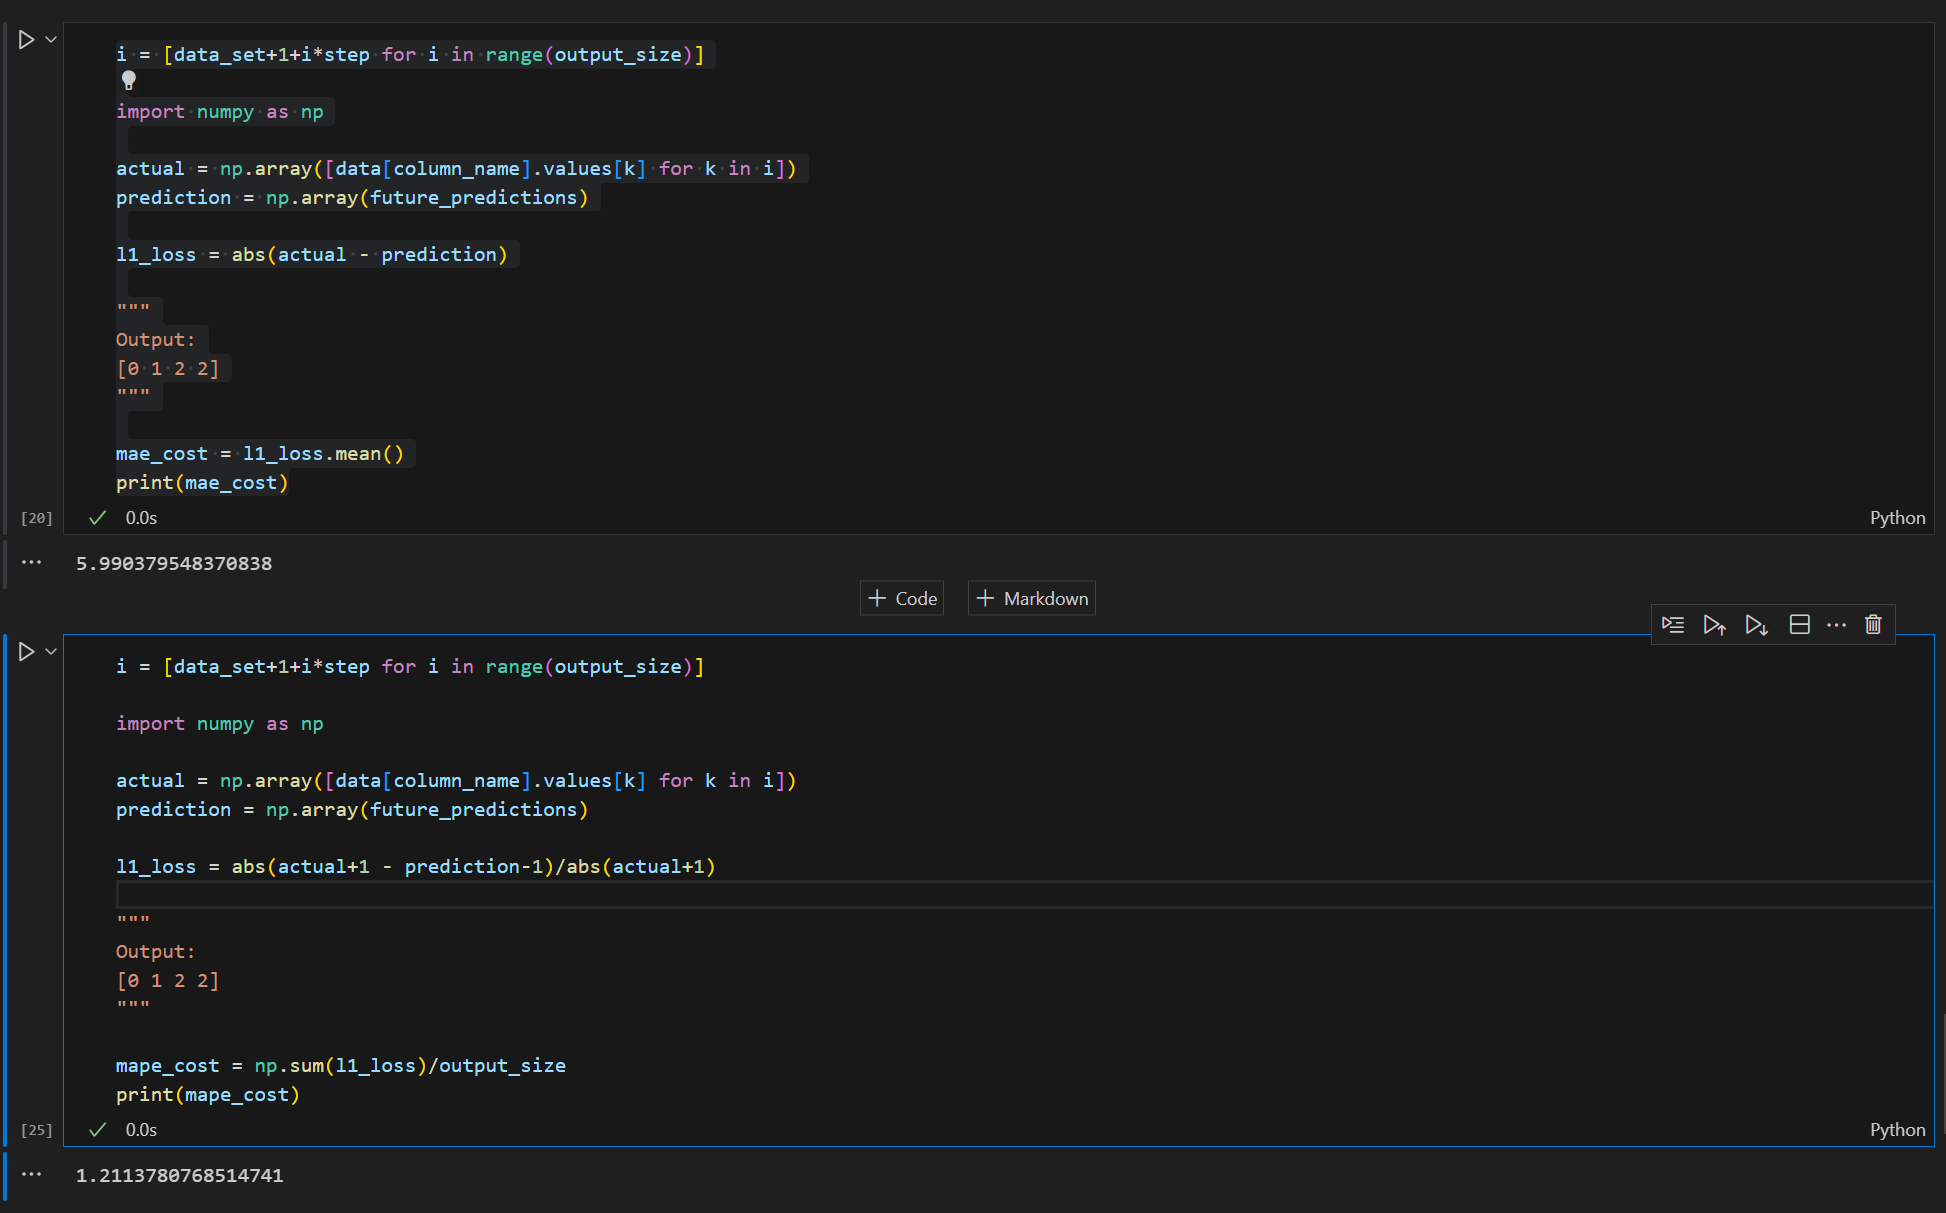
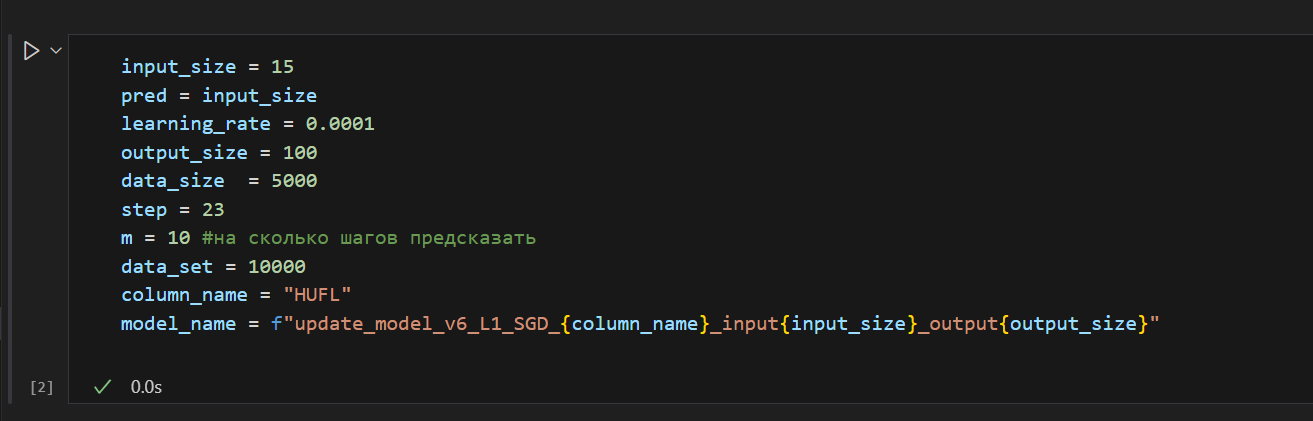

## Тест2
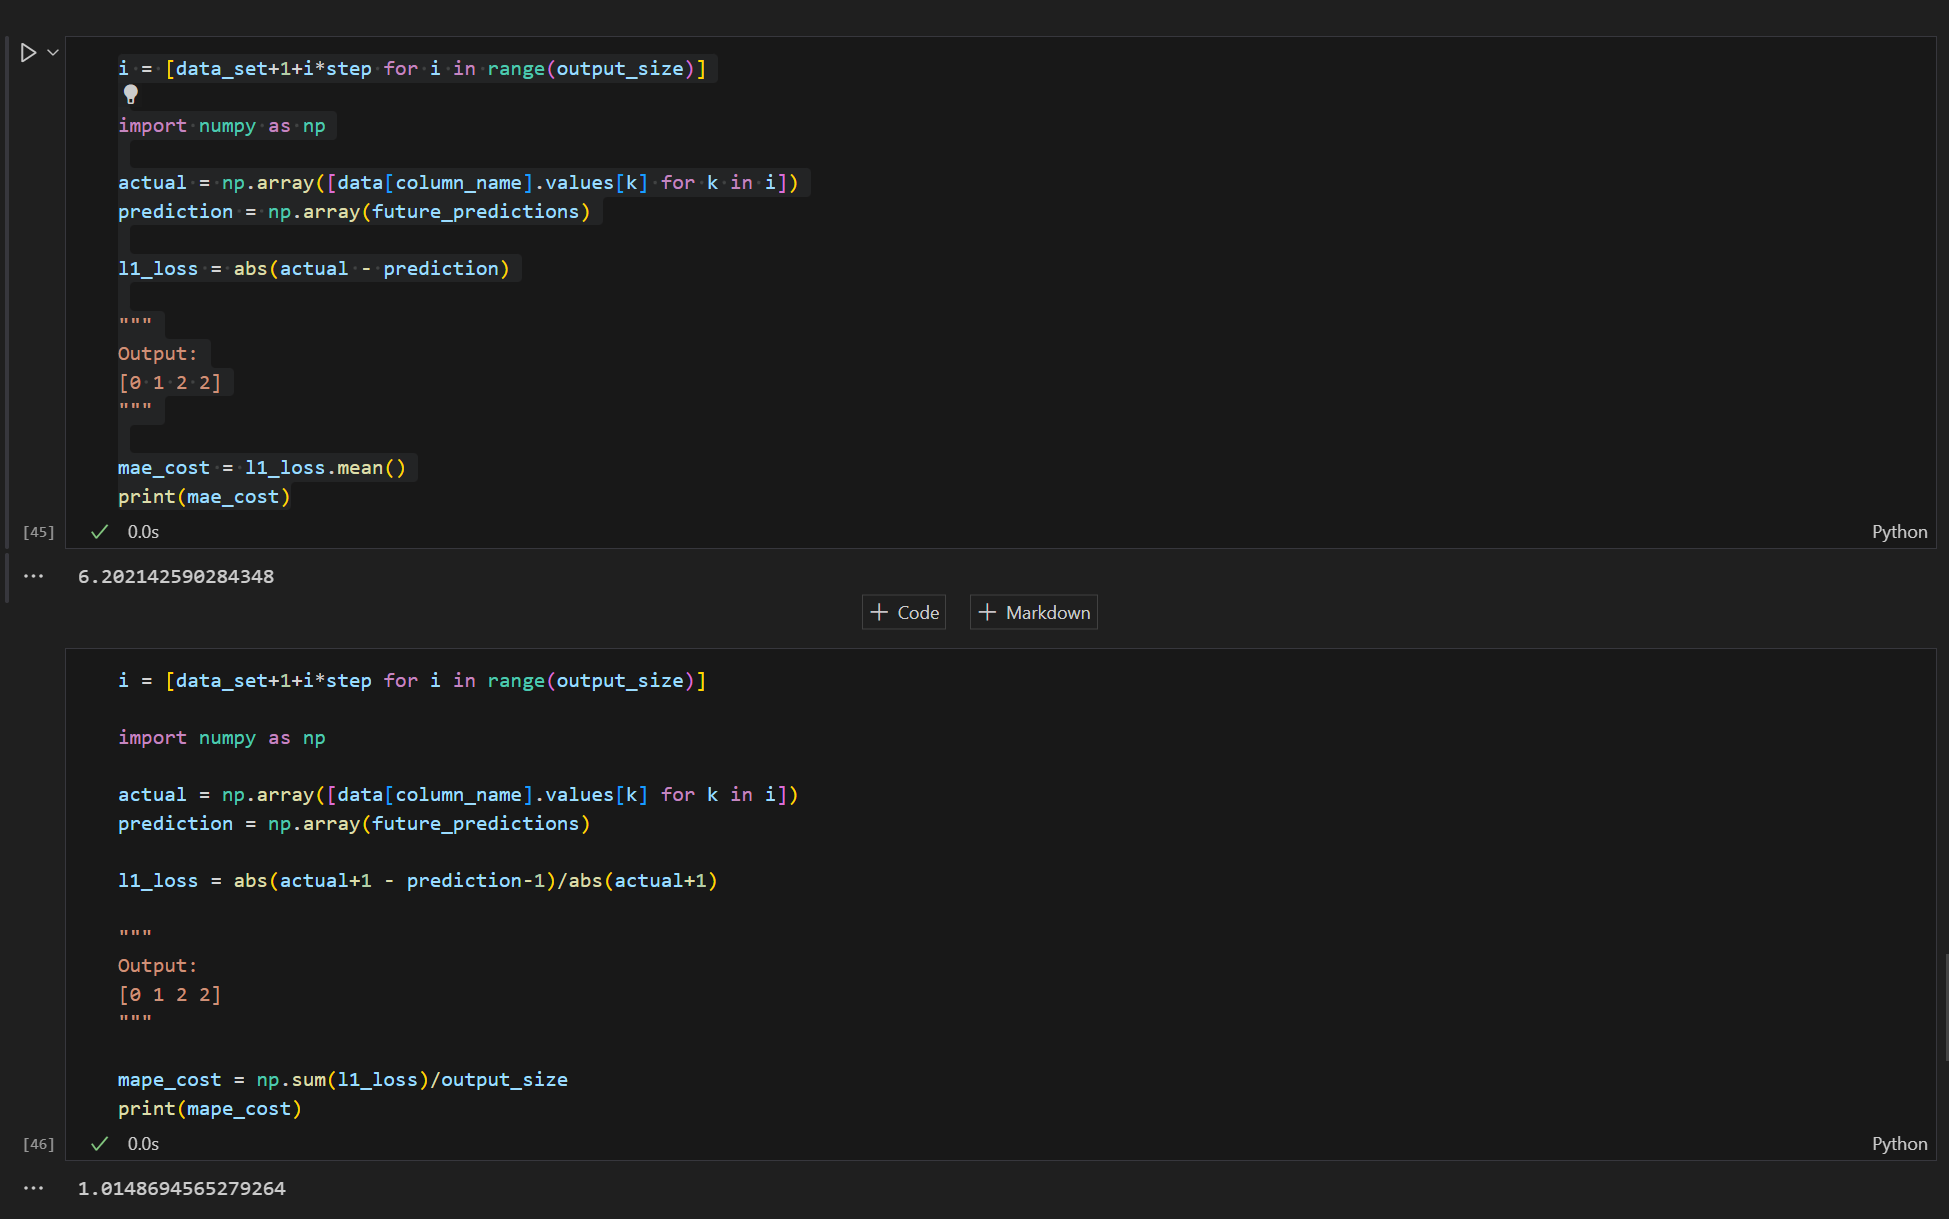
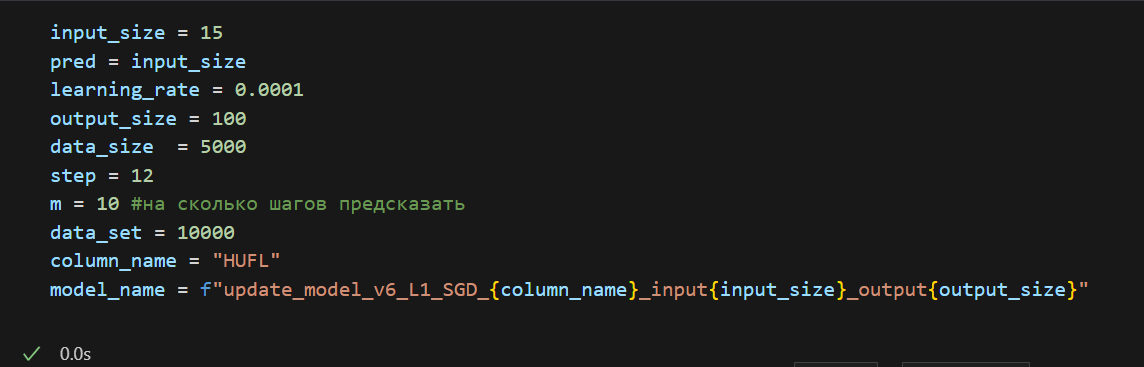


## Тест 3
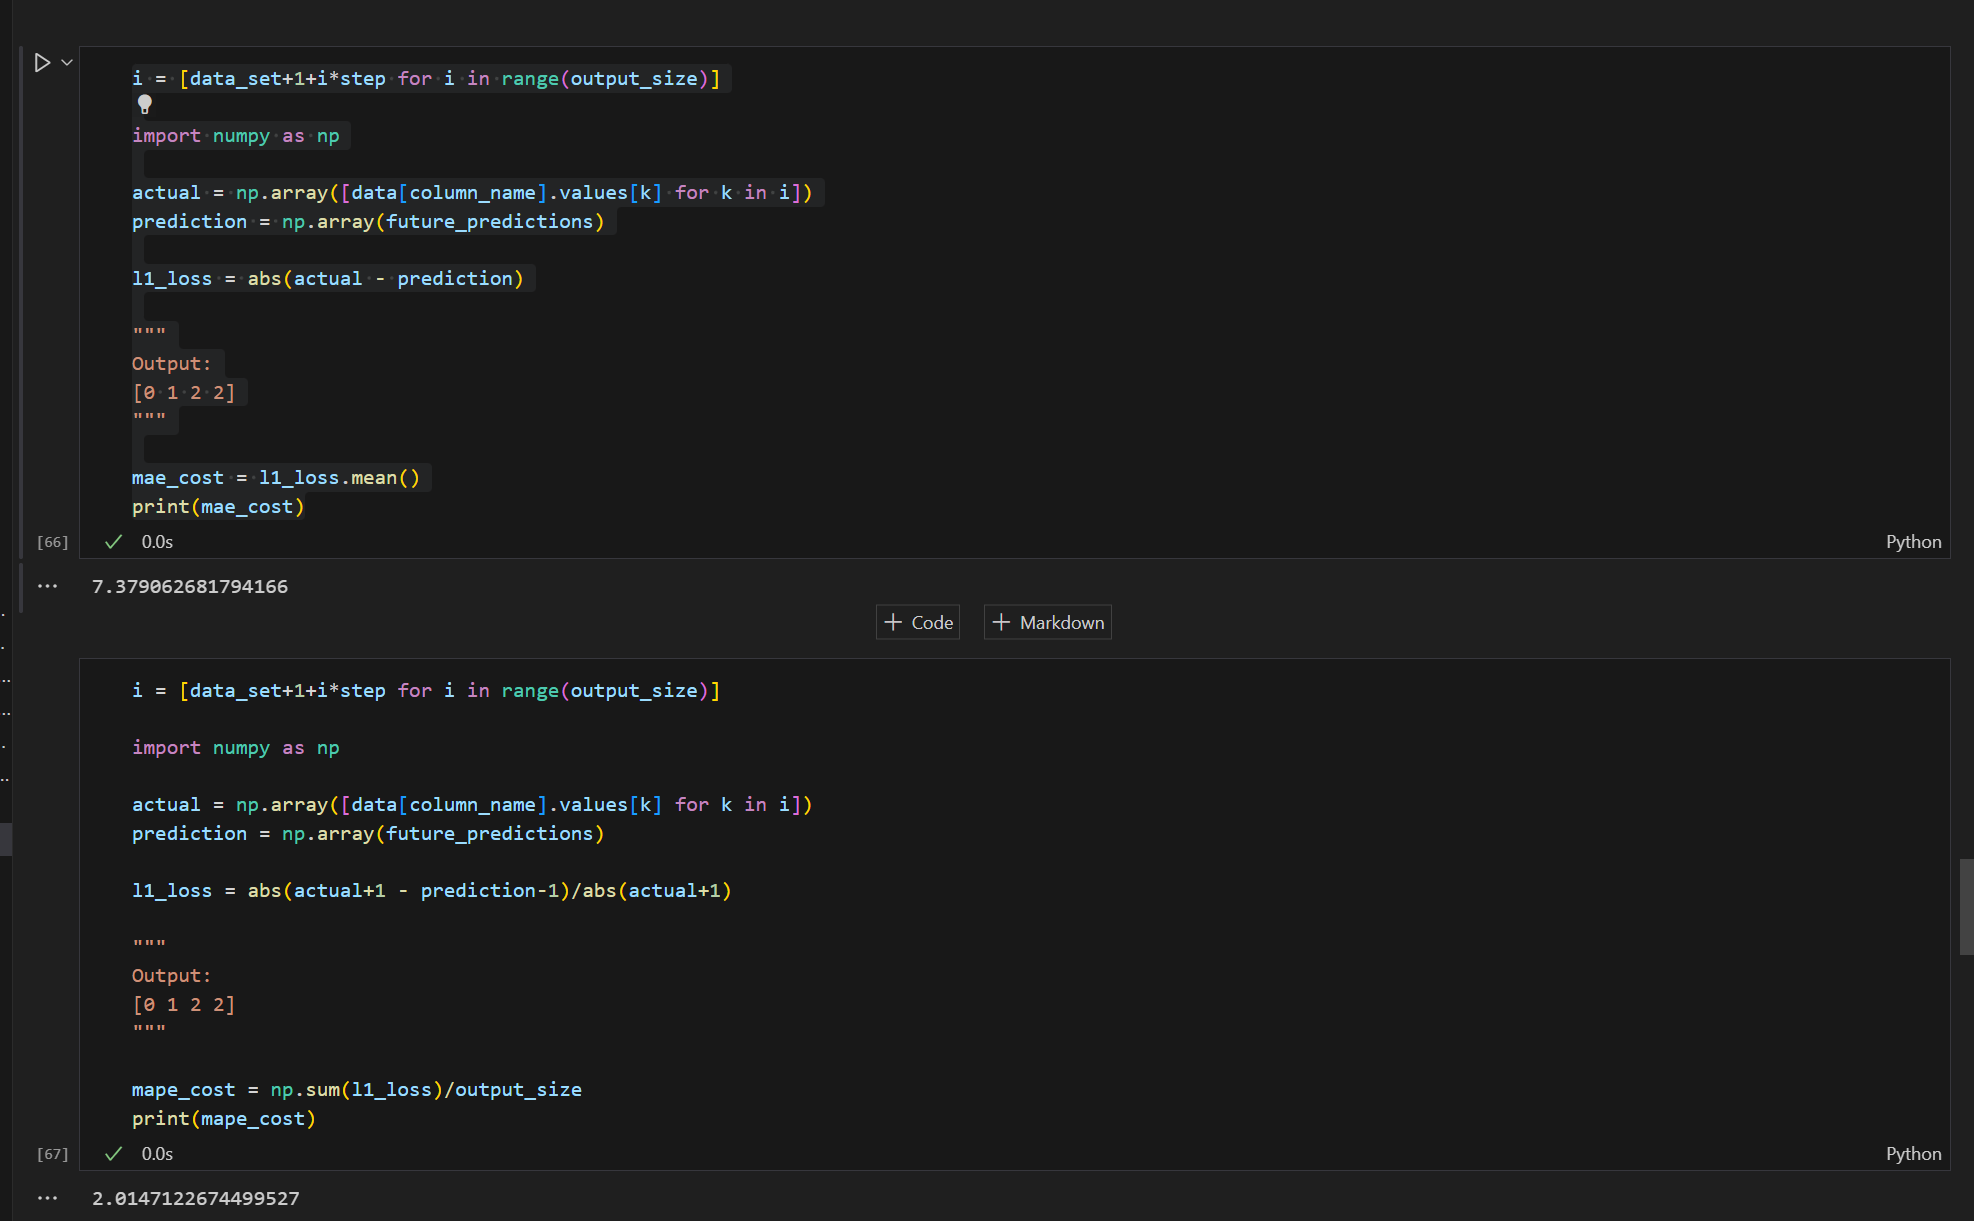
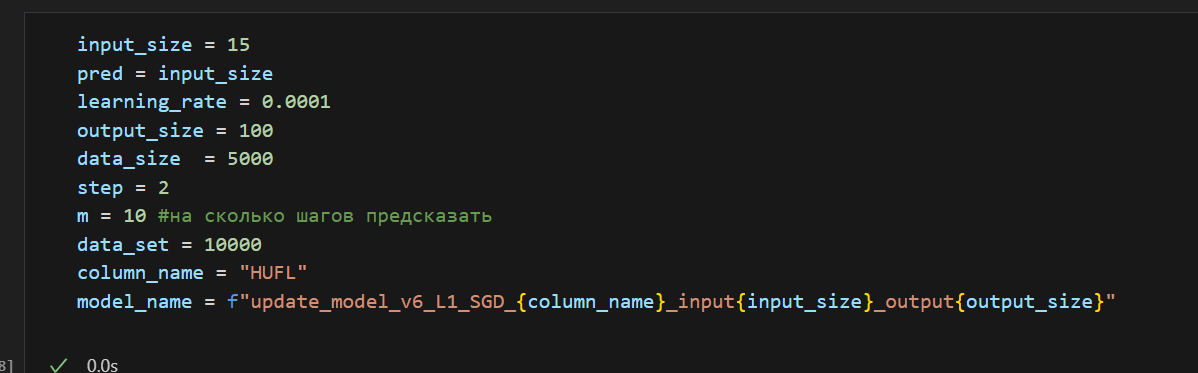

## Тест 4
